# EDA on full dataset 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

from importlib import reload

In [2]:
# pull in data

# full corpus
#df = pd.read_pickle("../../data/prd/Federal_RePORTER/FR-cleaned-2021FEB24.pkl")
df = pd.read_pickle("../../../data/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")



In [3]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [5]:
# agency distribution

df["DEPARTMENT"].value_counts()

HHS     511923
NSF     121718
USDA     29769
NASA     16005
DOD       7845
VA        5529
ED        1764
EPA       1540
Name: DEPARTMENT, dtype: int64

In [6]:
len(df)

696093

In [7]:
agency_counts = 100*df["DEPARTMENT"].value_counts()/len(df)
print(agency_counts)

HHS     73.542328
NSF     17.485882
USDA     4.276584
NASA     2.299262
DOD      1.127005
VA       0.794290
ED       0.253414
EPA      0.221235
Name: DEPARTMENT, dtype: float64


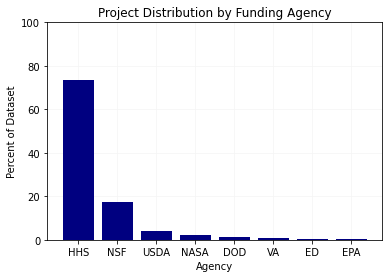

In [10]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.ylim(0,100)
plt.xlabel("Agency")
plt.ylabel("Percent of Dataset")
plt.title("Project Distribution by Funding Agency")

plt.savefig("../figures/agency_dist.png", dpi = 800, bbox_inches = "tight")

In [11]:
sum(df["PROJECT_START_DATE"].isna())  #0

0

In [12]:
# project start year distribution

# Extract Year from PROJECT_START_DATE - Sean's function from emerging topics code

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)


In [13]:
df["START_YEAR"] = df["START_YEAR"].astype('int')

In [15]:
df['START_YEAR'].value_counts()

2009    71046
2010    66147
2011    59709
2008    56590
2012    52638
2014    46195
2016    45480
2015    45372
2013    43959
2018    43225
2017    41921
2019    31167
2007    18263
2006    10510
2005     9522
2004     8038
2003     5093
1997     4507
2002     4487
2001     4407
2000     3635
1999     3475
1998     2677
1996     1851
1994     1598
1995     1436
1992     1269
1993     1179
1991     1136
1988      913
1990      845
1989      840
1987      704
1986      675
1985      665
1978      639
1983      637
1984      598
1977      506
1975      490
1979      463
1980      438
1982      393
1981      341
1976      336
2020       33
1974       32
1972        4
1970        4
1965        4
1973        1
Name: START_YEAR, dtype: int64

In [16]:
# number of projects with a start year before 2008

#df.dtypes
print(len(df[df['START_YEAR'] < 2008]))
print(100*len(df[df['START_YEAR'] < 2008])/len(df))

92611
13.30440041776027


In [17]:
# projects with start year of at least 2008

filt_df = df[df['START_YEAR'] >= 2008]
filt_df = filt_df[filt_df['START_YEAR'] < 2020]

In [18]:
year_counts = filt_df["START_YEAR"].value_counts()
print(year_counts)

2009    71046
2010    66147
2011    59709
2008    56590
2012    52638
2014    46195
2016    45480
2015    45372
2013    43959
2018    43225
2017    41921
2019    31167
Name: START_YEAR, dtype: int64


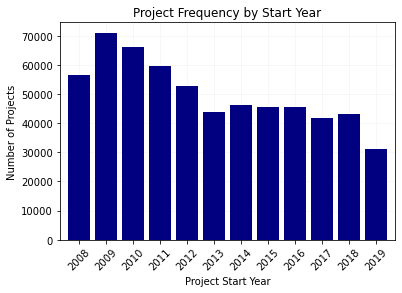

In [20]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xlim(2007.3, 2019.7)
plt.xticks(year, rotation=45)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year")

plt.savefig("../figures/startyr_freq.png", dpi = 800, bbox_inches = "tight")

In [21]:
# find number of projects funded by NIH

df["AGENCY"].value_counts()

NIH        503425
NSF        121718
NIFA        25625
NASA        16005
CDMRP        7593
VA           5529
ARS          3950
ALLCDC       3108
AHRQ         2739
IES          1764
FDA          1558
EPA          1540
NIDILRR       810
ACF           283
FS            194
CNRM          131
DVBIC          99
CCCRP          22
Name: AGENCY, dtype: int64

In [22]:
100*503425/511923

98.33998472426518

### Organization Names

Are these mainly colleges/universities?

In [54]:
df['ORGANIZATION_NAME'].isna().sum()

1376

In [55]:
df['ORGANIZATION_NAME'].value_counts()[20:40]

HARVARD UNIVERSITY                       5870
VANDERBILT UNIVERSITY                    5669
UNIVERSITY OF SOUTHERN CALIFORNIA        4851
BAYLOR COLLEGE OF MEDICINE               4832
UNIVERSITY OF ALABAMA AT BIRMINGHAM      4794
BRIGHAM AND WOMEN'S HOSPITAL             4789
UNIVERSITY OF FLORIDA                    4781
UNIVERSITY OF CHICAGO                    4773
UNIVERSITY OF CALIFORNIA BERKELEY        4721
OHIO STATE UNIVERSITY                    4599
UNIVERSITY OF CALIFORNIA IRVINE          4569
CORNELL UNIVERSITY ITHACA                4564
OREGON HEALTH AND SCIENCE UNIVERSITY     4423
UNIVERSITY OF COLORADO DENVER            4417
NORTHWESTERN UNIVERSITY AT CHICAGO       4268
MOUNT SINAI SCHOOL OF MEDICINE           4259
UNIVERSITY OF IOWA                       4040
MASSACHUSETTS INSTITUTE OF TECHNOLOGY    3969
UNIVERSITY OF UTAH                       3954
UNIVERSITY OF ARIZONA                    3945
Name: ORGANIZATION_NAME, dtype: int64

In [56]:
len(df['ORGANIZATION_NAME'].value_counts())

16940

In [83]:
count = 0
idx = []
higher_ed = ["university", "college", "univ", "school", "institute of technology", \
            "polytechnic institute"]


for i, org in enumerate(df['ORGANIZATION_NAME']):
    
    if type(org) == float and np.isnan(org):
        # do nothing
        pass
    else: 
        for term in higher_ed:
            if term in org.lower():
                count += 1
                idx.append(i)
                break
        
print(count)

515837


In [84]:
100*count/len(df)

74.10460958521347

In [85]:
not_idx = list(set(range(len(df))) - set(idx))

In [86]:
idx[0:10]

[0, 4, 5, 7, 8, 9, 10, 12, 13, 14]

In [87]:
not_idx[0:10]

[1, 2, 3, 6, 11, 18, 25, 26, 34, 49]

In [88]:
df['ORGANIZATION_NAME'].iloc[not_idx].value_counts()[0:20]

NATIONAL INSTITUTES OF HEALTH                 40607
MASSACHUSETTS GENERAL HOSPITAL                 6525
BRIGHAM AND WOMEN'S HOSPITAL                   4789
MAYO CLINIC                                    3291
SCRIPPS RESEARCH INSTITUTE                     2829
DANA-FARBER CANCER INSTITUTE                   2753
FRED HUTCHINSON CANCER RESEARCH CENTER         2725
SLOAN-KETTERING INSTITUTE FOR CANCER RES       2453
GEORGIA TECH RESEARCH CORPORATION              2350
CHILDREN'S HOSPITAL BOSTON                     2278
BETH ISRAEL DEACONESS MEDICAL CENTER           2249
CHILDREN'S HOSPITAL MEDICAL CENTER CINCI       2055
CLEVELAND CLINIC LERNER COL/MED-CWRU           1762
AGRICULTURAL RESEARCH SERVICE                  1738
CHILDRENS HOSPITAL OF PHILADELPHIA             1612
GORDON RESEARCH CONFERENCES                    1429
SANFORD-BURNHAM MEDICAL RESEARCH INSTITUTE     1184
H LEE MOFFITT CANCER CTR & RES INST             956
JACKSON LABORATORY                              953
ST JUDE CHIL

In [89]:
sum(df['ORGANIZATION_NAME'].iloc[not_idx].value_counts()[0:100])

119848

In [90]:
len(df)

696093

In [91]:
524291 in idx

True

In [92]:
df['ORGANIZATION_NAME'].iloc[524291]

'VIRGINIA POLYTECHNIC INSTITUTE'

In [93]:
len(list(set(df['ORGANIZATION_NAME'].iloc[not_idx])))

15912

In [94]:
df[df["ORGANIZATION_NAME"] == "GEORGIA TECH RESEARCH CORPORATION"]

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
102,117,90114,Enhanced Science of Science and Innovation Pol...,2008,Academy; Accounting; Address; Algorithms; Area...,TLS- MEASURING AND TRACKING RESEARCH KNOWLEDGE...,NSF,NSF,NaN,0830207,9/15/2008,8/31/2012,"PORTER, ALAN L","RAFOLS, ISMAEL",05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,30332-0420,UNITED STATES,NaN,NaN,47.075,2008,402530.0,NaN,1,1,"[enhance, science, science, innovation, policy..."
126,143,90140,"PI: Ghovanloo, MaysamProposal Number: 0828882P...",2008,age group; Algorithms; arm; Assisted Living Fa...,WIRELESS TRACKING OF TONGUE MOVEMENTS FOR WHEE...,NSF,NSF,NaN,0828882,1/1/2009,12/31/2010,"GHOVANLOO, MAYSAM",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,30332-0420,UNITED STATES,NaN,NaN,47.041,2008,172899.0,NaN,1,1,"[pi, ghovanloo, maysamproposal, number, 082888..."
140,161,89924,LAB-ON-A-CHIP APPLICATIONS OF PERMANENT NONWET...,2008,biochip; interest; Knowledge; Lab-On-A-Chips; ...,LAB-ON-A-CHIP APPLICATIONS OF PERMANENT NONWET...,NASA,NASA,NaN,NNX08BB04G,6/6/2008,6/5/2012,"NEITZEL, PAUL",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,30332-0001,UNITED STATES,NaN,NaN,43.001,2008,100000.0,NaN,1,1,"[lab, on_a, chip, application, permanent, nonw..."
190,216,89875,Computer Science (31)This collaborative projec...,2008,computer science; Computers; Data Analyses; Ed...,COLLABORATIVE PROPOSAL: PROBLEM-BASED LEARNING...,NSF,NSF,NaN,0836908,1/15/2009,8/31/2011,"LEE, HSIEN-HSIN S",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,30332-0420,UNITED STATES,NaN,NaN,47.076,2008,54843.0,NaN,1,1,"[computer, science, collaborative, project, cr..."
196,224,89867,IMPROVEMENT OF LI-ION BATTERY ANODES THROUGH S...,2008,Anodes; base; Deposition; Goals; improved; Ion...,IMPROVEMENT OF LI-ION BATTERY ANODES THROUGH S...,NASA,NASA,NaN,NNX08BA93H,8/1/2008,7/31/2011,"YUSHIN, GLEB",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,30332-0001,UNITED STATES,NaN,NaN,43.AAA,2008,90000.0,NaN,1,1,"[improvement, li, ion, battery, anode, si, nan..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693931,1111543,1174067,﻿ DESCRIPTION (provided by applicant): Re...,2019,Aberrant DNA Methylation; Age; Alzheimer's Dis...,HUMAN SPECIFIC BRAIN DNA METHYLATION AND NEURO...,HHS,NIH,NIMH,5R01MH103517-05,4/1/2015,1/31/2021,"YI, SOOJIN","PREUSS, TODD M ;",05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,303320415,UNITED STATES,2/1/2019,1/31/2021,93.242,2019,669322.0,NaN,1,1,"[recent, methodological, advance, genomics, ne..."
694114,1111726,1177744,﻿ DESCRIPTION (provided by applicant): Most ...,2019,3-Dimensional; Antibiotic Resistance; Bacteria...,MECHANISMS OF POLYMICROBIAL SYNERGY IN WOUND I...,HHS,NIH,NIGMS,5R01GM116547-05,1/1/2016,12/31/2020,"WHITELEY, MARVIN",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,303320415,UNITED STATES,1/1/2019,12/31/2020,93.859,2019,286234.0,NaN,1,1,"[bacterial, pathogenesis, study, focus, mono_c..."
694764,1112382,1123643,Sensory processing is a way to understand neur...,2019,Action Potentials; Affect; area striata; Atten...,CIRCUIT AND SYNAPTIC MECHANISMS OF VISUAL SPAT...,HHS,NIH,NINDS,5R01NS109978-02,9/30/2018,7/31/2023,"HAIDER, BILAL",NaN,05,097394084,GEORGIA TECH RESEARCH CORPORATION,ATLANTA,GA,303320415,UNITED STATES,8/1/2019,7/31/2020,93.853,2019,436654.0,NaN,1,1,"[sensory, processing, way, understand, neural,..."
695281,1112900,1148647,﻿ DESCRIPTION (provided by applicant): The e...,2019,Abdomen; Abdominal Cavity; Affect; Ant

In [82]:
df[df["DUNS_NUMBER"] == "003321619"]

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
13035,13884,150162,&bull; Develop approaches to identify outcome-...,2008,Air; base; cardiovascular health; Data; Data S...,DEVELOPMENT AND ASSESSMENT OF ENVIRONMENTAL IN...,EPA,EPA,NaN,R833626,10/1/2007,9/30/2010,"RUSSELL, ARMISTEAD","MULHOLLAND, JAMES; SARNAT, JEREMY; KLEIN, MITC...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,499512.0,NaN,1,1,"[bull, develop, approach, identify, outcome, b..."
13400,14443,150271,The objective of this program is to take the o...,2008,Anatoxins; Antibodies; aptamer; Area; Bacteria...,APTAMER CAPTURE AND OPTICAL INTERFEROMETRIC DE...,EPA,EPA,NaN,R833839,6/1/2008,4/30/2011,"ELLINGTON, ANDY","CAMPBELL, DANIEL P ; XU, JIE",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,600000.0,NaN,1,1,"[objective, program, optical, interferometric,..."
74496,117052,150128,"As laid out in the proposal, the main objectiv...",2009,Acute; Air; base; Biomass; Carbon; Chemicals; ...,IMPROVING PARTICULATE MATTER SOURCE APPORTIONM...,EPA,EPA,NaN,R833866,12/1/2008,11/30/2012,"MARMUR, AMIT","RUSSELL, ARMISTEAD (TED) ; MULHOLLAND, JAMES; ...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,899956.0,NaN,1,1,"[lay, proposal, main, objective, research, tes..."
139152,229103,150152,"As described in the proposal for this grant, t...",2010,Address; Affect; Air; Applications Grants; Bio...,REGIONAL AIR QUALITY MANAGEMENT ASPECTS OF GLO...,EPA,EPA,NaN,R834281,10/1/2009,9/30/2012,"TSIMPIDI, AP","RUSSELL, ARMISTEAD (TED) ; NENES, ATHANASIOS; ...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,599963.0,NaN,1,1,"[describe, proposal, grant, test, follow, hypo..."
139227,229178,150516,The Georgia Tech Bike-share (GTB) system is a ...,2010,Bicycling; cost; Infrastructure; Names; System,ON-BIKE AUTOMATED BIKE SHARE SYSTEM,EPA,EPA,NaN,SU834706,8/15/2010,8/14/2011,"SHEN, ALICE","PANTEV, ANTON; BRAS, BERT; AZEVEDO, KYLE; DOSH...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,10000.0,NaN,1,1,"[georgia_tech, bike_share, gtb, system, unique..."
260357,412636,909302,To provide a chemically comprehensive data set...,2011,Aerosols; Air; Air Pollution; ambient particle...,DEVELOPMENT AND DEPLOYMENT OF AN INSTRUMENTATI...,EPA,EPA,NaN,R834799C001,1/1/2011,12/31/2016,"NENES, ATHANASIOS","MULHOLLAND, JAMES; SARNAT, JEREMY; STRICKLAND,...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,NaN,NaN,1,1,"[provide, chemically, comprehensive, data, set..."
320185,487348,150243,Prescribed burning (PB) is an important part o...,2012,Air; base; Data; hazard; Modeling; Names; Risk...,DYNAMIC MANAGEMENT OF PRESCRIBED BURNING FOR B...,EPA,EPA,NaN,R835217,6/1/2012,5/31/2015,"CHAN, DANIEL","TIAN, DI; ODMAN, MEHMET TALAT ; CHANG, MICHAEL...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,500000.0,NaN,1,1,"[prescribe, burn, pb, important, land, managem..."
320190,487353,150248,Atmospheric systems are strongly affected by e...,2012,Affect; Air; Climate; Event; Future; Link; Nam...,AIR QUALITY IMPACTS OF EXTREME WEATHER EVENTS:...,EPA,EPA,NaN,R835204,6/1/2012,5/31/2015,"ZHANG, HENIAN","LOADHOLT, JAY; PARK, TAEWON; ZENG, TAO; DENG, ...",NaN,003321619,GEORGIA INSTITUTE OF TECHNOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,749859.0,NaN,1,1,"[atmospheric, system, strongly, affect, extrem..."
324910,493346,673128,The purpose is to explain why and how four U.S...,2012,Cities; Comparative Study; Development; Distre...,OVERCOMING BROWNFIELD 